## Building an Image Classification Model for use in Video reel Generation

## Step 1: Imports

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Step 2: Data Preprocessing

## -- Let's check the distribution of data.

In [ ]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Datasets/test/PetImages/Dog'))
n_cats = len(os.listdir('/content/drive/MyDrive/Colab Notebooks/Datasets/test/PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

## -- Create Directories for Training and Validation

In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/test')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
    os.mkdir('/tmp/cats-v-dogs/test/cats')
    os.mkdir('/tmp/cats-v-dogs/test/dogs')
except OSError:
    print('Error failed to make directory')

In [ ]:
#Define data path
CAT_DIR = '/content/drive/MyDrive/Colab Notebooks/Datasets/test/PetImages/Cat'
DOG_DIR = '/content/drive/MyDrive/Colab Notebooks/Datasets/test/PetImages/Dog'

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

0
0
0
0
0
0


## -- Create a function to Split the Data

In [ ]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

## -- Calling the function to create Training/Validation Data

In [ ]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', '/tmp/cats-v-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs','/tmp/cats-v-dogs/test/dogs',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!


## -- Checking the Data Directories

In [ ]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs')))

print(len(os.listdir('/tmp/cats-v-dogs/validation/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/validation/dogs')))


print(len(os.listdir('/tmp/cats-v-dogs/test/cats')))
print(len(os.listdir('/tmp/cats-v-dogs/test/dogs')))

11277
11268
627
626
627
626


## -- Create Generators

In [ ]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)

In [ ]:
train_generator = train_gen.flow_from_directory(
        '/tmp/cats-v-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        '/tmp/cats-v-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 22543 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.


## -- Ensure correct Data is obtained

In [ ]:
class_names = ['Cat', 'Dog']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

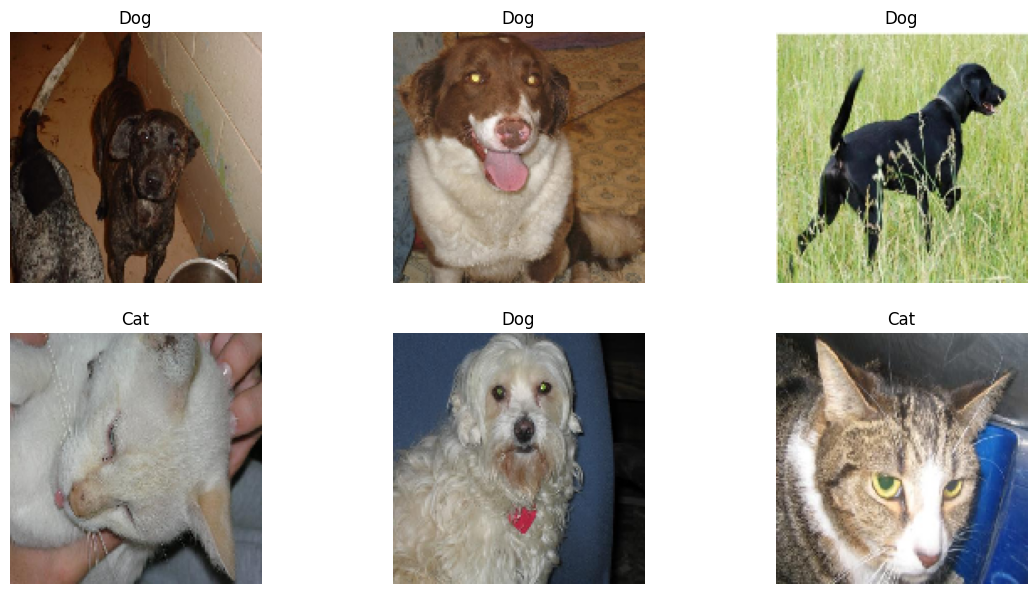

In [ ]:
plot_data(train_generator,7)

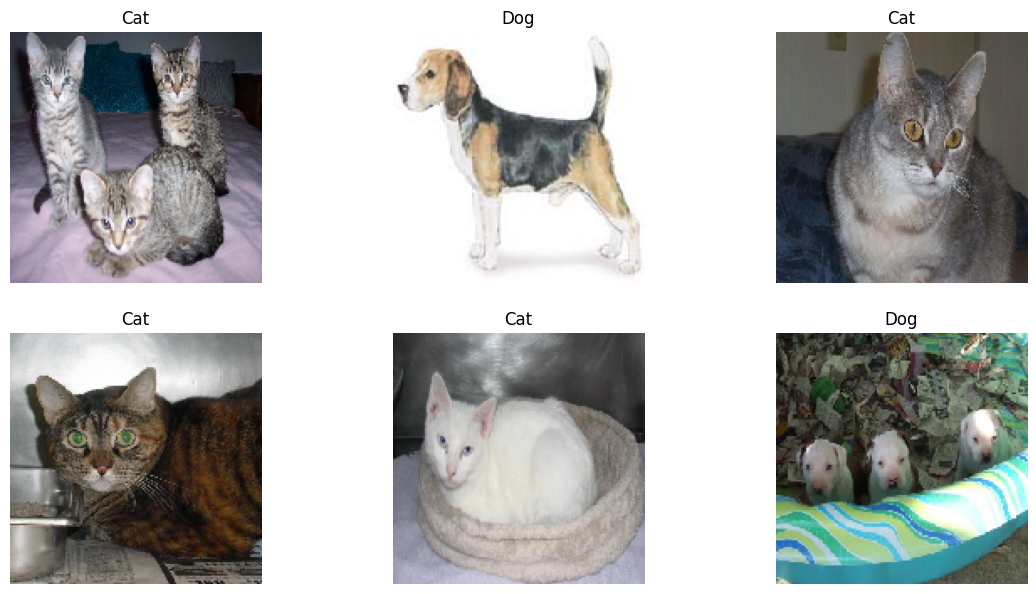

In [ ]:
plot_data(validation_generator,7)

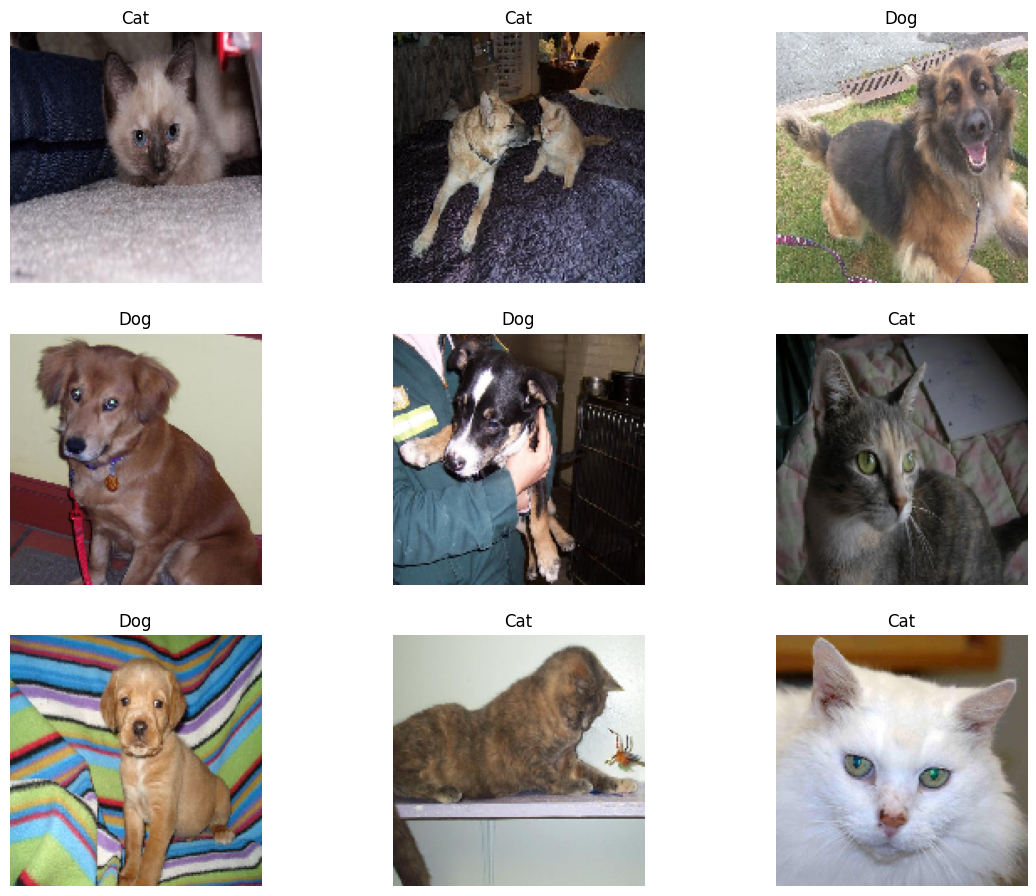

In [ ]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

## Step 3: Model

In [ ]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r = model.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10
353/353 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5477

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



353/353 [==============================] - 60s 170ms/step - loss: 0.6842 - accuracy: 0.5477 - val_loss: 0.6718 - val_accuracy: 0.5603
Epoch 2/10
353/353 [==============================] - 58s 163ms/step - loss: 0.6415 - accuracy: 0.6297 - val_loss: 0.6216 - val_accuracy: 0.6528
Epoch 3/10
353/353 [==============================] - 57s 161ms/step - loss: 0.6129 - accuracy: 0.6758 - val_loss: 0.6052 - val_accuracy: 0.6664
Epoch 4/10
353/353 [==============================] - 58s 164ms/step - loss: 0.5831 - accuracy: 0.6977 - val_loss: 0.6622 - val_accuracy: 0.6433
Epoch 5/10
353/353 [==============================] - 58s 163ms/step - loss: 0.5649 - accuracy: 0.7147 - val_loss: 0.6022 - val_accuracy: 0.6696
Epoch 6/10
353/353 [==============================] - 57s 163ms/step - loss: 0.5462 - accuracy: 0.7269 - val_loss: 0.5601 - val_accuracy: 0.7087
Epoch 7/10
353/353 [==============================] - 57s 161ms/step - loss: 0.5317 - accuracy: 0.7401 - val_loss: 0.5358 - val_accuracy: 0.7

## Step 4: Evaluation

## -- Evaluate the Model on the Test Set

In [ ]:
if INCLUDE_TEST:
    model.evaluate(test_generator)

20/20 [==============================] - 4s 171ms/step - loss: 0.4563 - accuracy: 0.7885


## -- Visualize the Predictions

In [ ]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

2/2 [==============================] - 2s 11ms/step


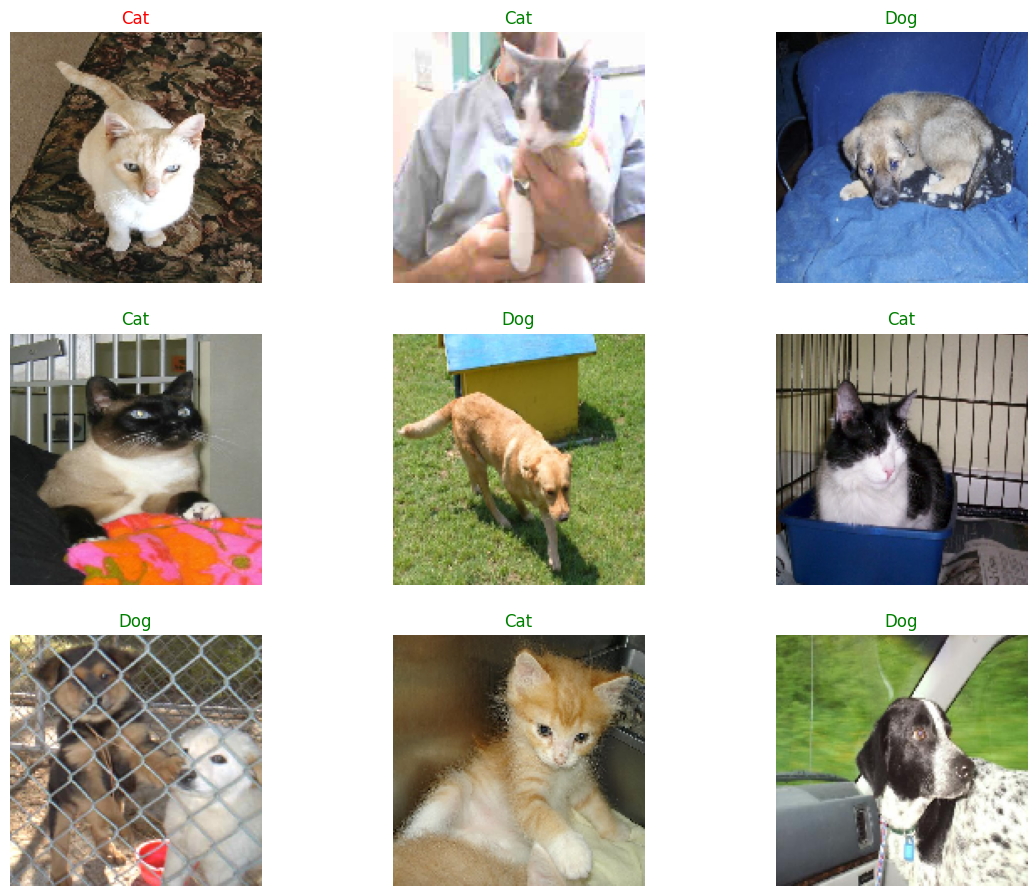

In [ ]:
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

2/2 [==============================] - 0s 32ms/step


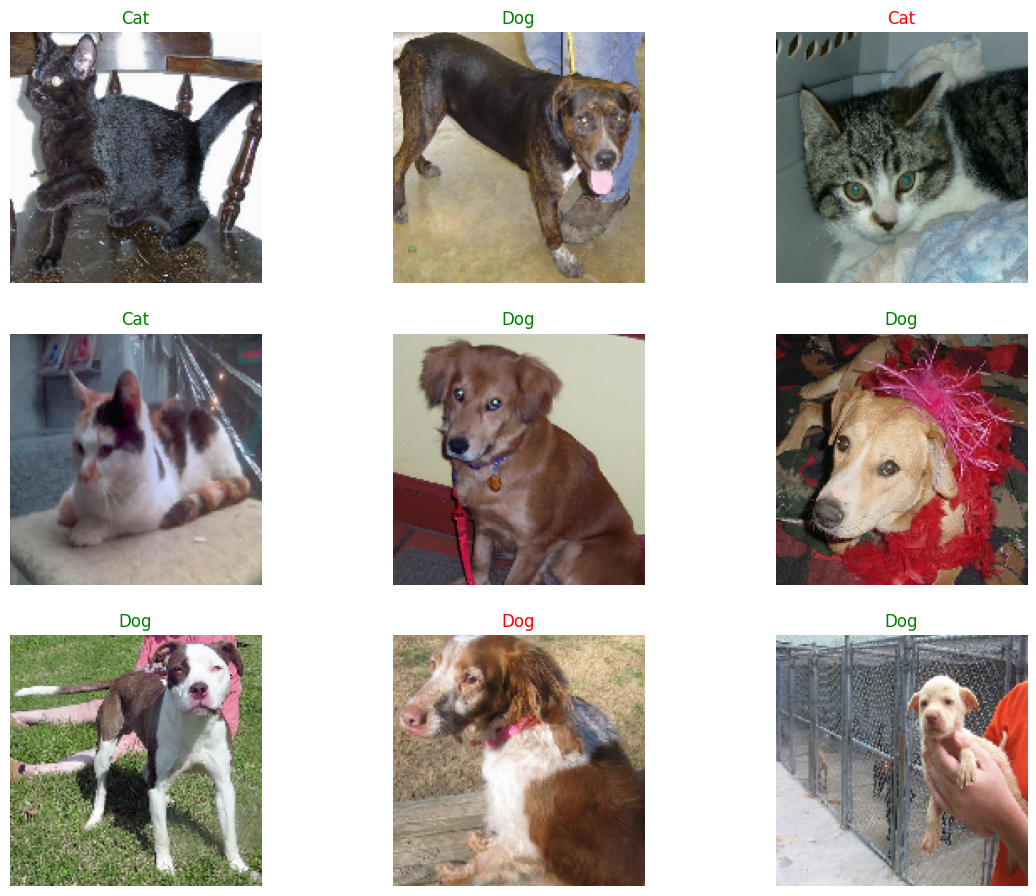

In [ ]:
plot_prediction(validation_generator, 10)

## -- Visualize the Class Activation Maps

In [ ]:
# Create a  model to visualize activation maps
gp_weights =  model.get_layer('dense').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

In [ ]:
# Use the model to make predictions on the test generator
images, _ = test_generator.next()
features, results = activation_model.predict(images)

2/2 [==============================] - 0s 14ms/step


In [ ]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image

    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [ ]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated
    '''
    counter = 0
    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

Predicted Class = Dog, Probability = 0.51288533


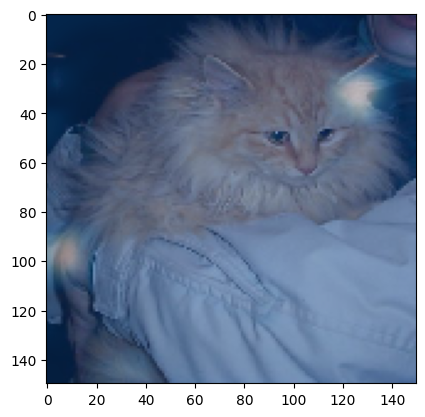

Predicted Class = Dog, Probability = 0.5826912


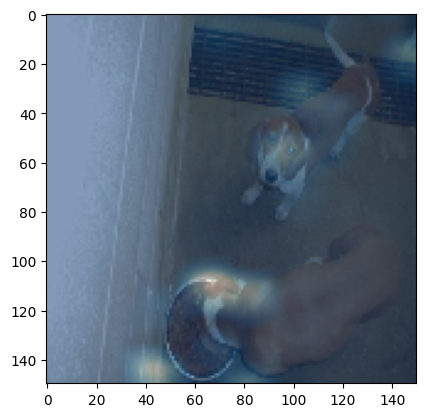

Predicted Class = Dog, Probability = 0.769191


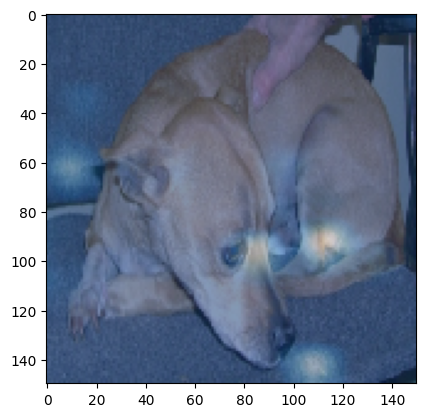

Predicted Class = Dog, Probability = 0.6948698


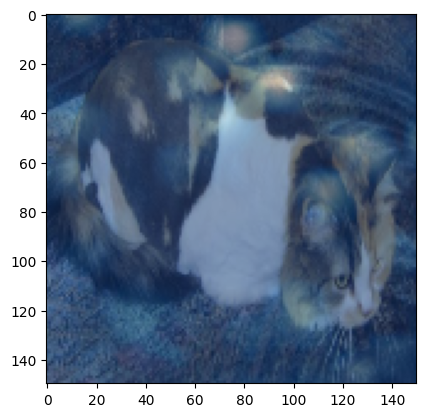

Predicted Class = Dog, Probability = 0.77135247


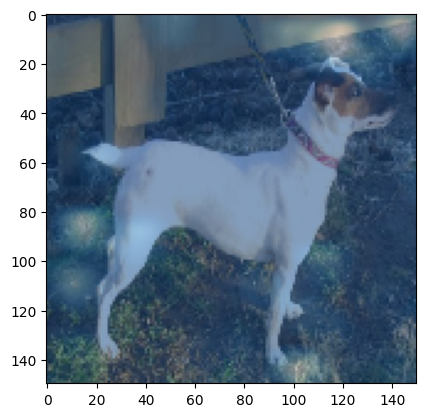

In [ ]:
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.8084528


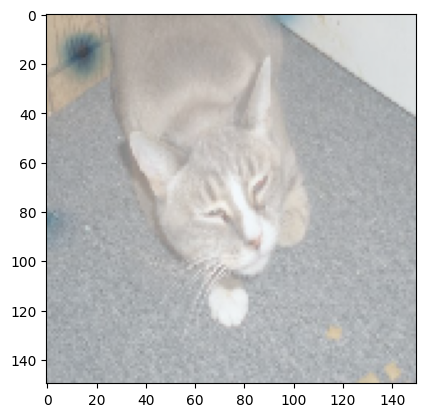

Predicted Class = Cat, Probability = 0.7751352


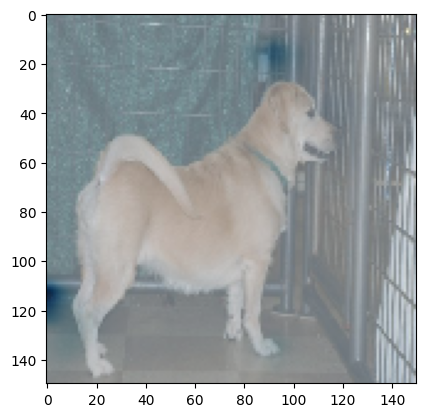

Predicted Class = Cat, Probability = 0.86040384


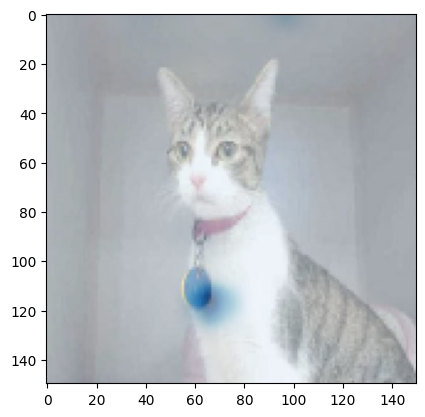

Predicted Class = Cat, Probability = 0.791005


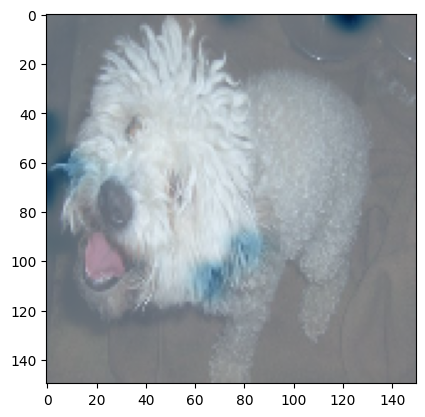

Predicted Class = Cat, Probability = 0.7495046


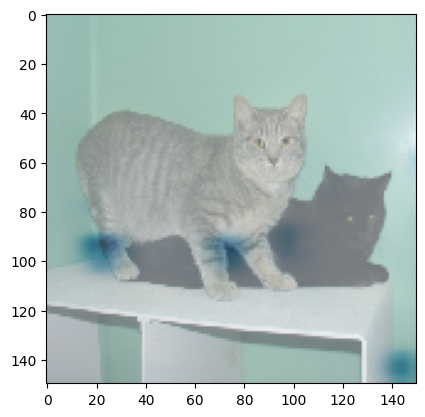

In [ ]:
show_maps(desired_class=0, num_maps=5)

## -- Visualize Training Process

In [ ]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  0.546207  0.726878  0.560100      0.708699
6  0.531701  0.740052  0.535801      0.730247
7  0.512817  0.755002  0.545995      0.735036
8  0.499621  0.762365  0.484796      0.772546
9  0.481062  0.775851  0.456265      0.788508

In [ ]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [ ]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(
    title_font_color="#fad25a",
    xaxis=dict(color="#fad25a",title='Epochs'),
    yaxis=dict(color="#fad25a")
 )
fig.show()